#Importing Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization
)


In [ ]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
   
    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

In [ ]:
# setting up the input image width

IMG_WIDTH=416

In [ ]:
# setting up the 9 Anchor boxes and anchor masks to be used as the index of anchors.



yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / IMG_WIDTH
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])


In [ ]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):

  # this function creates the convolution layer of the darknet network 
  # refer the image
  
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm)(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

In [ ]:
def DarknetResidual(x, filters):
  # this function creates one residual connection block of the darknet network 
  # refer the image
  
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x

In [ ]:
def DarknetBlock(x, filters, blocks):
  # this function creates the residual blocks of the darknet network 
  # refer the image
  

    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

In [ ]:
def Darknet(name=None):

  # this function creates the whole bottom up darknet network by using all the functions created till now.
  # refer the image

  # this function returns the functional model of the darknet
  
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2) 
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8) # skip connection
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [ ]:
def YoloConv(filters, name=None):
  # this function implements the FPN part of yolo v3
  # refer the image

    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

In [ ]:
def YoloOutput(filters, anchors, classes, name=None):
  # this function implements the detection part of yolo v3
  # refer the image
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

In [ ]:
def yolo_boxes(pred, anchors, classes):

    # this function processes the output of the network 
    # it returns the corner co-ordinates of the bounding box, the box confiedence score and the class probabilities


    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1) 

    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box


In [ ]:
def yolo_nms(outputs, anchors, masks, classes):

  # this function applies nms on the bouding boxes
    # boxes, conf, class_prob
    b, c, t = [], [], []

    for o in outputs:
      b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
      c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
      t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
            iou_threshold=0.5,
            score_threshold=0.5,
            max_output_size_per_class=147,
            max_total_size=147
    )

    return boxes, scores, classes, valid_detections #len(boxes)

In [ ]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
           masks=yolo_anchor_masks, classes=80, training=False):
  
  # this function applies all the functions together to implement yolo v3
    x = inputs = Input([size, size, channels])

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')

In [ ]:
def draw_outputs(img, outputs, class_names):

    # this function draws the result over the image
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img,nums


In [ ]:
def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

In [ ]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

def load_darknet_weights(model, weights_file):

    #this function loads the weight from the .weights file
    a=1
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    layers = YOLOV3_LAYER_LIST
    
    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

           
            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

   

In [ ]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from seaborn import color_palette
import cv2

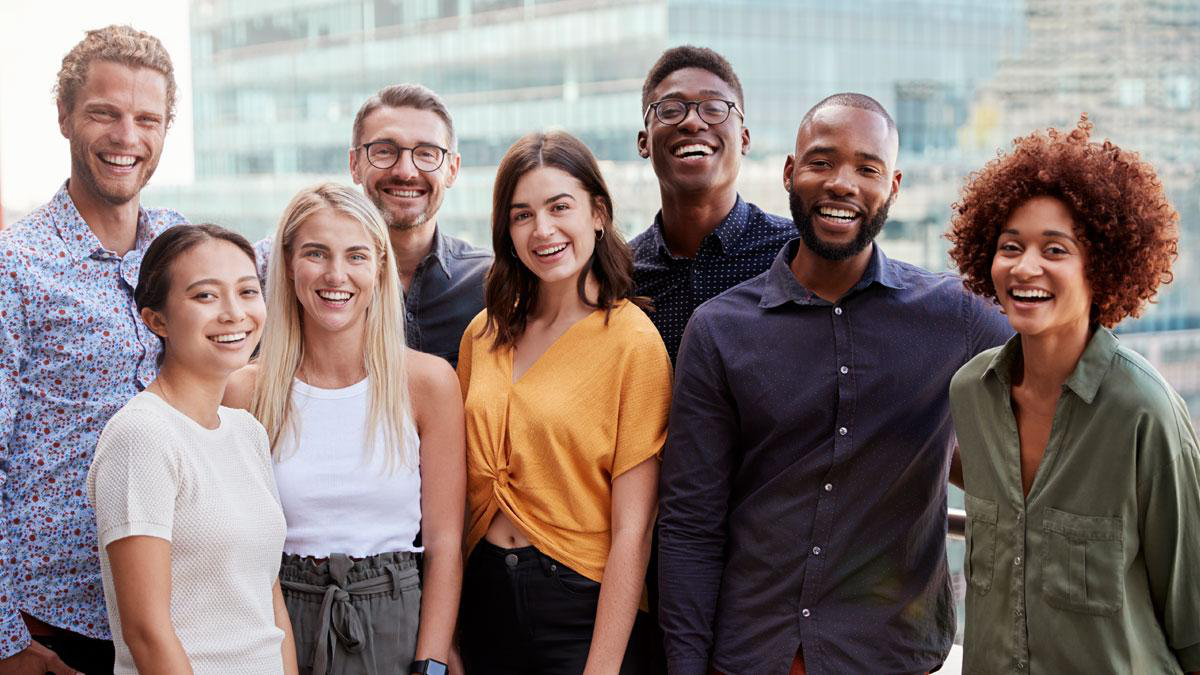

In [ ]:
img="/content/audience-citizen_0.jpg"
display(Image.open(img))

In [ ]:
# processing the input image


img = tf.image.decode_image(open('/content/audience-citizen_0.jpg', 'rb').read(), channels=3)
img = tf.expand_dims(img, 0)
img_test = transform_images(img, 416)
#img_test=transform_images('/content/eagle.jpg',416)


In [ ]:
# reads the class names

class_names = [c.strip() for c in open('/content/coco.names').readlines()]

In [ ]:
n_classes=len(class_names)


In [ ]:
iou_threshold = 0.5
confidence_threshold = 0.5

In [ ]:
 # applying the YoloV3 function
 
 
 yolo = YoloV3(classes=n_classes)

In [ ]:
# loads the weight to the model

load_darknet_weights(yolo,'/content/yolov3.weights')

In [ ]:
# passing he image to the model.

boxes, scores, classes, nums = yolo(img_test)

In [ ]:
img = cv2.imread('/content/audience-citizen_0.jpg')
img,nums = draw_outputs(img, (boxes, scores, classes, nums), class_names)
print(nums)

# saving the output image
cv2.imwrite('/content/op_gi.jpg', img)

tf.Tensor(8, shape=(), dtype=int32)


True

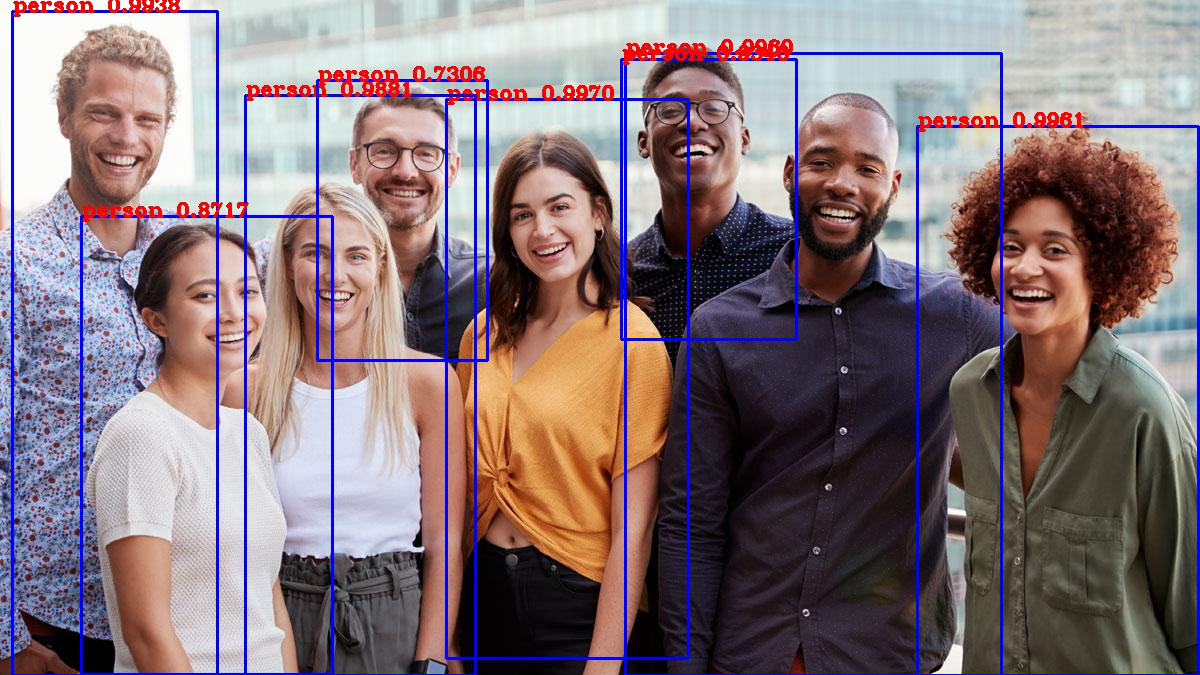

In [ ]:
display(Image.open('/content/op_gi.jpg'))